# dHybridR Example Notebook

#### Here we provide an example of some of the functions a analysis notebook might use when computing velocity space signatures.

In [1]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [2]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load Analysis Input

In [3]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"

In [4]:
print(path,vmax,dv,numframe,dx,xlim,ylim,zlim)

M06_th45/ 15.0 0.5 2000 0.5 [15.0, 30.0] [0.0, 12.0] [0.0, 12.0]


### Load data

In [5]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

In [6]:
dfields.keys()

dict_keys(['bx', 'bx_xx', 'bx_yy', 'bx_zz', 'by', 'by_xx', 'by_yy', 'by_zz', 'bz', 'bz_xx', 'bz_yy', 'bz_zz', 'ex', 'ex_xx', 'ex_yy', 'ex_zz', 'ey', 'ey_xx', 'ey_yy', 'ey_zz', 'ez', 'ez_xx', 'ez_yy', 'ez_zz', 'Vframe_relative_to_sim'])

In [7]:
import time
start = time.time()
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  584.373532295227


In [8]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

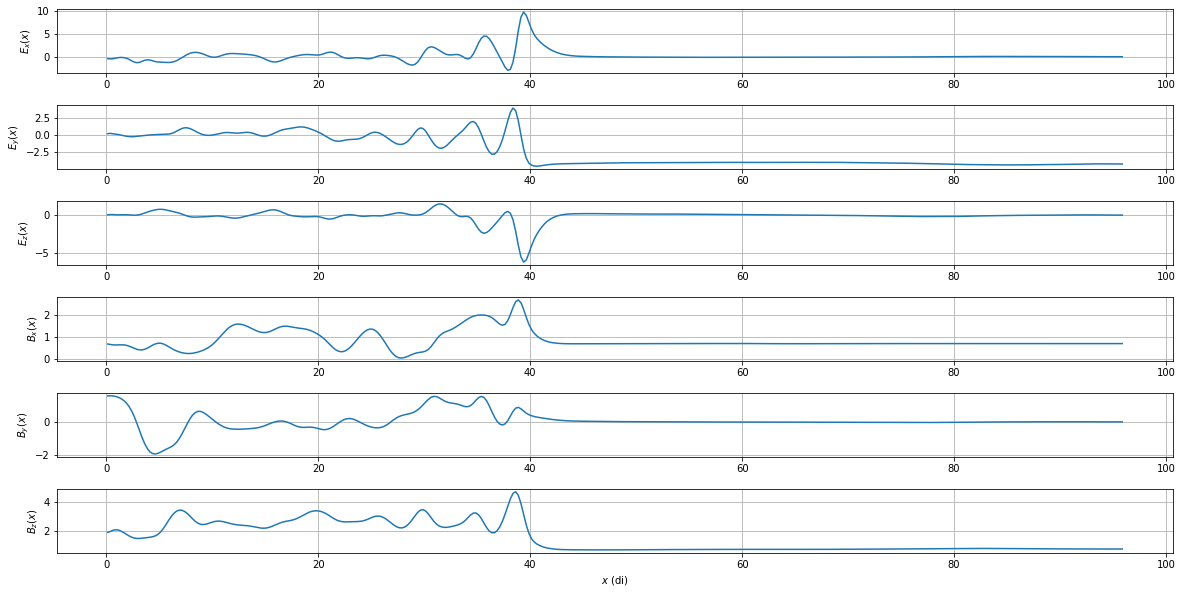

In [9]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

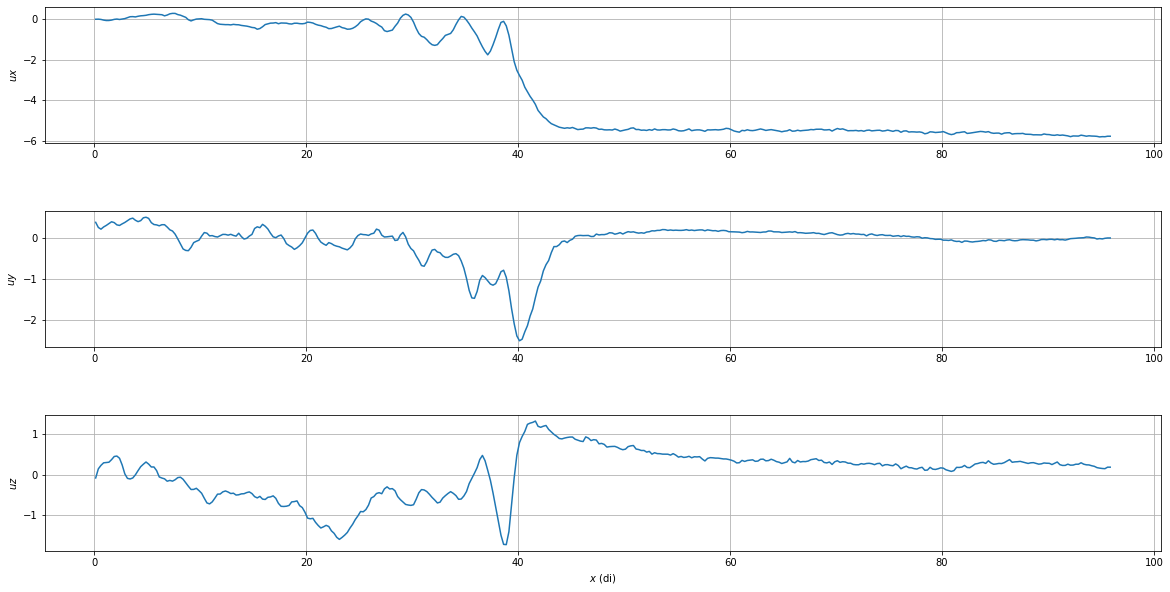

In [10]:
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

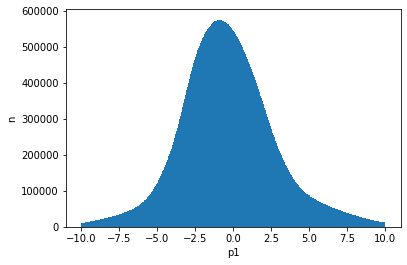

In [11]:
pltdebug.plot_1d_dist(dparticles, 'p1', 10., xlim[0], xlim[1], ylim[0], ylim[1])

### Compute Shock Vel and Lorentz transform fields

In [ ]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)


In [ ]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

In [ ]:
plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [ ]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

In [ ]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

In [ ]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 17.5#lower bound for metadata = 1 (di)
endval = 21.5 #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [20]:
metadata = md.build_metadata(xlim,dx, startval, endval)

In [21]:
metadata

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

### Test super plot

In [ ]:
x1 = xlim[0]
x2 = xlim[1]
y1 = ylim[0]
y2 = ylim[1] 
z1 = zlim[0] 
z2 = zlim[1]

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [ ]:
totalPtcl

In [ ]:
CEx = CEx_in[0]
CEy = CEy_in[0]
CEz = CEz_in[0]
Hist = Hist_in[0]
vx = vx_in
vy = vy_in
vz = vz_in

#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [ ]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = fpc.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock,xlim=xlim,ylim=ylim,zlim=zlim)

### Make superplot gif

In [ ]:
pltvv.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

In [ ]:
rsltmng.make_gif_from_folder('superplotGraphs','superplottest.gif')

### Convert to previous '2v FPC' formatting
#### Here we projected our CEi(x;vz,vy,vx) data to CEi(x;vx,vy) to match the formatting of old data projects

In [ ]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_2v = []
CEy_2v = []
CEz_2v = []
for i in range(0,len(CEx)):
    CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
    CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
    CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
    CEx_2v.append(CEx_xy)
    CEy_2v.append(CEy_xy)
    CEz_2v.append(CEz_xy)
    
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
x_out = x

#### Compute energization from correlations

In [ ]:
#TODO: update to use CEi(x;vx,vy,vz) object
enerCEx_out = anl.compute_energization_over_x(CEx_2v,dv)
enerCEy_out = anl.compute_energization_over_x(CEy_2v,dv)
enerCEz_out = anl.compute_energization_over_x(CEz_2v,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [ ]:
inputdict = dnc.parse_input_file(path)

In [ ]:
params = dnc.build_params(inputdict,numframe)

In [14]:
#TODO: remove 'old' format from code and update function names
savenewfmt = True
flnm = '3Vtest1.nc'

In [ ]:
if(savenewfmt):
    try:
        dnc.save3Vdata(Hist, CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.save3Vdata(Hist, CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
else:
    flnm = '2Vtest.nc'
    try:
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)

### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [59]:
if(savenewfmt):
    Hist_in, CEx_in, CEy_in, CEz_in, vx_in, vy_in, vz_in, x_in, enerCEx_in, enerCEy_in, enerCEz_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load3Vnetcdf4(flnm)
else:
    CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load_netcdf4(flnm)

### Perform sanity checks
#### E cross B gif

In [ ]:
#TODO: update make_velsig_gif_with_EcrossB to handle CEi(x;vz,vy,vx) object rather than CEi(x;vx,vy) object and work for all vx,vy vx,vz vy,vz projections
CEx_xy = [ao.array_3d_to_2d(CEx[i],'xy') for i in range(0,len(CEx))]
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.make_velsig_gif_with_EcrossB(vx_xy, vy_xy, vmax, CEx_xy, 'ex', x_out, dx, dfields, 'CExExB', 'CExExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CExExB', 'CExExB.gif')

<img src="CExExB.gif" width="750" align="center">

In [ ]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_in, 'ex', x_out, dx, dfields, 'CEyExB', 'CEyExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CEyExB', 'CEyExB.gif')

<img src="CEyExB.gif" width="750" align="center">

##  Plot fields as a function of time

In [ ]:
#Plots Ex(x=xxpltpoint,y=0,z=0;t)
xxpltpoint = 20.0 #di
xxindex = ao.find_nearest(dfields['ex_xx'], xxpltpoint)
plt1d.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [ ]:
anl.get_abs_max_velocity(dparticles)

###  Making field pmesh

In [ ]:
xxindex = 164
plt2d.make_field_pmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

In [ ]:
plt2d.make_field_pmesh(dfields,'bz','xz',takeaxisaverage=False,yyindex = 0,xlimmin=35,xlimmax=45)

In [ ]:
xx = 40.0
xxindex = ao.find_nearest(dfields['ex_xx'], xx)
plt2d.compare_pmesh_fields_yz(dfields, flnm = '', ttl ='x (di): ' + str(dfields['ex_xx'][xxindex]), takeaxisaverage=False, xxindex=xxindex)

In [ ]:
plt2d.compare_pmesh_fields_yz_sweep(dfields,'pmeshsweep')

In [ ]:
rsltmng.make_gif_from_folder('pmeshsweep', 'pmeshsweep.gif')

### Estimate Ripple size

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

### Test Energization vs J dot E (WIP)

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
dflowtransform = ft.transform_flow(dflow,vshock)
pltdebug.check_JiEi_vs_CEi(dfields,dflowtransform,dparticles,x_in,enerCEx_in,enerCEy_in,dx,xlim=xlim,ylim=ylim,zlim=zlim)

### Test log space distribution plot

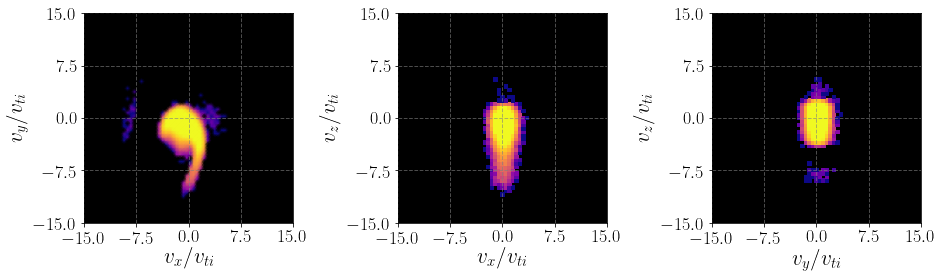

In [272]:
#TODO: fix smoothing of 2nd and 3rd plot
pltvv.dist_log_plot_3dir(vx_in, vy_in, vz_in, vmax, Hist_in[1], flnm = '',ttl='')